In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# mapped classes are now created with names by default
# matching that of the table name.
# reflect the tables

inspector = inspect(engine)
inspector.get_table_names()



['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#print columns 'measurement'
columns = inspector.get_columns('measurement')

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#print columns 'station'
columns = inspector.get_columns('station')

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#print last date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.date, Measurement.prcp]
precip = session.query(*sel).filter(Measurement.date >= '2016-08-23').all()

precip_df = pd.DataFrame(precip)
precip_df.head(10)

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
5,2016-08-28,0.01
6,2016-08-29,0.00
7,2016-08-30,0.00
8,2016-08-31,0.13
9,2016-09-01,0.00


In [58]:
# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
# queryResults = engine.execute('SELECT * FROM Measurement Where dateadd(month dateiff(month)) ').fetchall()
import datetime as dt
from dateutil.relativedelta import relativedelta

latest = session.query(Measurement).order_by(Measurement.date.desc()).first().date
last_year = datetime.datetime.strptime(latest, '%Y-%m-%d')+ relativedelta(months=-12)
last_year = str(last_year)[:10]

def query_to_dict(rset):
    result = defaultdict(list)
    for obj in rset:
        instance = inspect(obj)
        for key, x in instance.attrs.items():
            result[key].append(x.value)
    return result


rset = session.query(Measurement).filter(Measurement.date >= last_year).all()
    # Give me a DataFrame
    # Inconvenient: it's not well ordered (e.g. 'id' is not the first)
df = pd.DataFrame(query_to_dict(rset))
df


# # Save the query results as a Pandas DataFrame and set the index to the date column
# df = pd.read_sql(
#     'SELECT strftime(\'%Y-%m-%d\',date) as month ,sum(prcp) FROM Measurement GROUP BY month order by month desc LIMIT 364',
#     con=engine
# )

# # Sort the dataframe by date

# # Use Pandas Plotting with Matplotlib to plot the data
# df = df.set_index('month')
# df

,id,station,date,prcp,tobs
0,2364,USC00519397,2016-08-23,0.00,81.0
1,2365,USC00519397,2016-08-24,0.08,79.0
2,2366,USC00519397,2016-08-25,0.08,80.0
3,2367,USC00519397,2016-08-26,0.00,79.0
4,2368,USC00519397,2016-08-27,0.00,77.0
...,...,...,...,...,...
2225,19546,USC00516128,2017-08-19,0.09,71.0
2226,19547,USC00516128,2017-08-20,NaN,78.0
2227,19548,USC00516128,2017-08-21,0.56,76.0
2228,19549,USC00516128,2017-08-22,0.50,76.0


Text(0, 0.5, 'Inches')

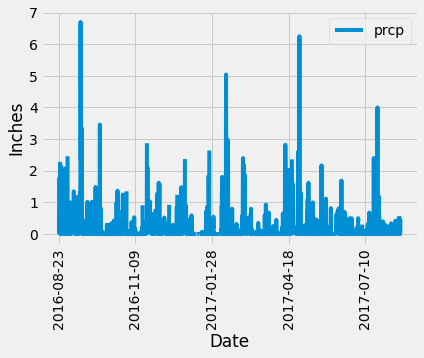

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
precip_df = precip_df.set_index("date")
precip_df.sort_values("date").plot(rot= "90")
plt.xlabel("Date")
plt.ylabel("Inches")


In [16]:
session.query(Measurement.date).count()

19550

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df['prcp'].rename('precipitation').to_frame().describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
sel = [Station.station]
station_count = session.query(func.count(*sel)).all()
station_count


[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.station)]
stationactivity = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stationactivity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
 # Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [
    Measurement.station,
   func.max(Measurement.tobs),
   func.min(Measurement.tobs),
   func.avg(Measurement.tobs)
    ]
max_temps = session.query(*sel).filter(Measurement.station == 'USC00519281' ).all()
max_temps

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

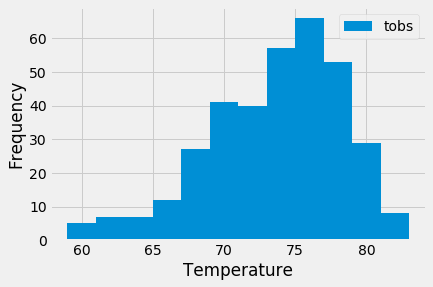

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.date, Measurement.tobs]
temps = session.query(*sel).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281' ).all()

temp_df = pd.DataFrame(temps)

temp_df.plot.hist(bins=12)
plt.xlabel("Temperature")

## Bonus Challenge Assignment

In [164]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [165]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
